In [2]:
%matplotlib inline
import pandas as pd

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
# Access for Google BigQuery
from pandas.io import gbq
project_id = 'fluted-galaxy-165204'

We first take a look at the data format as provided by the official site of bay area bike share program. The data set from the official site is divided by year. The first set of data contains data from 8/29/13 (system launch) to 2/28/14.

For each time period, there are 4 separate csv files:

1.Station information

In [6]:
stations_query="""
#standardSQL
SELECT *
FROM
  `bigquery-public-data.san_francisco.bikeshare_stations`
"""

In [7]:
df_stations = gbq.read_gbq(stations_query, project_id=project_id, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Processed: 21.0 kb

Retrieving results...
Got 276 rows.

Total time taken 5.61 s.
Finished at 2017-05-18 21:51:42.


In [8]:
df_stations = df_stations.sort_values('station_id').drop_duplicates(subset='station_id')
print 'Number of stations:', len(df_stations)

Number of stations: 74


2.Station status data: 
(Note that the status data file is quite large, we load only the first 1000 rows for now)

In [9]:
station_status = pd.read_csv('data/201402_babs_open_data/201402_status_data.csv', nrows=1000, index_col=None)
station_status.head()
# If chopping by chunk, use below
#chunksize = 10 ** 7
#for chunk in pd.read_csv('data/201402_babs_open_data/201402_status_data.csv', chunksize=chunksize):
#    print chunk.head()

,station_id,bikes_available,docks_available,time
0,2,2,25,2013/08/29 12:06:01
1,2,2,25,2013/08/29 12:07:01
2,2,2,25,2013/08/29 12:08:01
3,2,2,25,2013/08/29 12:09:01
4,2,2,25,2013/08/29 12:10:01


3.Trip data:

In [10]:
trips_query="""
SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
"""

df_trips = gbq.read_gbq(trips_query, project_id=project_id, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 1; 3.0% done. Elapsed 7.49 s.
  Got page: 2; 6.0% done. Elapsed 13.52 s.
  Got page: 3; 10.0% done. Elapsed 20.4 s.
  Got page: 4; 13.0% done. Elapsed 27.91 s.
  Got page: 5; 16.0% done. Elapsed 35.41 s.
  Got page: 6; 19.0% done. Elapsed 42.26 s.
  Got page: 7; 23.0% done. Elapsed 49.23 s.
  Got page: 8; 26.0% done. Elapsed 55.25 s.
  Got page: 9; 29.0% done. Elapsed 61.94 s.
  Got page: 10; 32.0% done. Elapsed 68.69 s.
  Got page: 11; 36.0% done. Elapsed 77.71 s.
  Got page: 12; 39.0% done. Elapsed 84.47 s.
  Got page: 13; 42.0% done. Elapsed 90.83 s.
  Got page: 14; 45.0% done. Elapsed 104.43 s.
  Got page: 15; 49.0% done. Elapsed 112.39 s.
  Got page: 16; 52.0% done. Elapsed 119.68 s.
  Got page: 17; 55.0% done. Elapsed 127.08 s.
  Got page: 18; 58.0% done. Elapsed 141.4 s.
  Got page: 19; 61.0% done. Elapsed 148.64 s.
  Got page: 20; 65.0% done. Elapsed 155.37 s.
  Got page: 21; 68.0

4.Weather data:

In [11]:
weather = pd.DataFrame.from_csv('data/201402_babs_open_data/201402_weather_data.csv', index_col=None)
weather.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Cloud_Cover,Events,Wind_Dir_Degrees,zip
0,8/29/2013,74,68,61,61,58,56,93,75,57,...,10,10,23,11,28.0,0,4,NaN,286,94107
1,8/30/2013,78,69,60,61,58,56,90,70,50,...,10,7,29,13,35.0,0,2,NaN,291,94107
2,8/31/2013,71,64,57,57,56,54,93,75,57,...,10,10,26,15,31.0,0,4,NaN,284,94107
3,9/1/2013,74,66,58,60,56,53,87,68,49,...,10,10,25,13,29.0,0,4,NaN,284,94107
4,9/2/2013,75,69,62,61,60,58,93,77,61,...,10,6,23,12,30.0,0,6,NaN,277,94107


## Station information
Let's start with some static information, e.g. station info 

Note: This could still potentially change (slowly) over time, as the program may adjust the stations according to the demand

Number of stations: 74


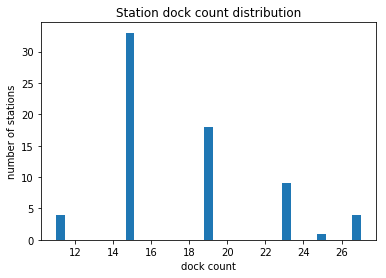

In [13]:
# station dock count histogram
print "Number of stations: " + str(len(df_stations))
ax = stations.dockcount.plot(kind='hist', bins=df_stations.dockcount.max())
ax.set(xlabel='dock count', ylabel='number of stations', title='Station dock count distribution')

We may also visualize the station location on google map.

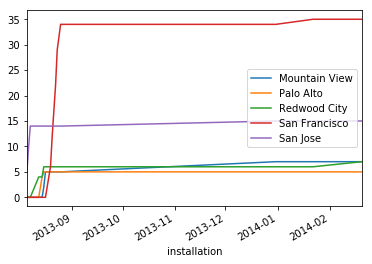

In [19]:
# Station installation history by area
temp = stations.groupby(['landmark', 'installation']).size()
temp = temp.unstack('landmark').fillna(0).cumsum(axis=0)
ax = temp.plot()
ax.legend(loc='right')

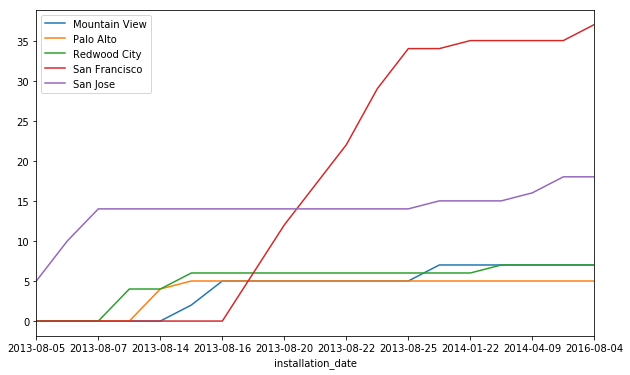

In [110]:
# Station installation history by area
import matplotlib.pyplot as plt
temp = df_stations.groupby(['landmark', 'installation_date']).size()
temp = temp.unstack('landmark').fillna(0).cumsum(axis=0)
ax = temp.plot(figsize=(10,6))
ax.legend(loc='upper left')

(Note: Need to adjust x-axis ticks)

## Trip data

[<matplotlib.text.Text at 0x1f60f3f10>, <matplotlib.text.Text at 0x1f60df890>]

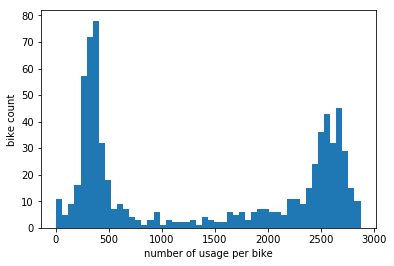

In [28]:
# Count the number of usage for each bike and plot the distribution
ax = df_trips['bike_number'].value_counts().plot(kind='hist', bins=50)
ax.set(xlabel='number of usage per bike', ylabel='bike count')

We could see from above that the number of usage per bike could be roughly separated into two groups. In this case, these might be two groups of bikes that are activated at different times. (* Requires further verification)

A related question we may ask is that:

Are there specific set of bicycles that are used more often than others? If so, is it because they are usually located at popular stations (or other reasons)?

This question may be relevant to the maintenance, as the number of usage may be related to the chance of malfunctioning.

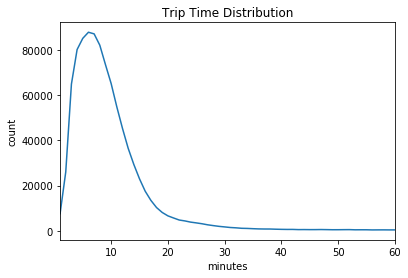

In [132]:
# Trip time distribution
#tripTime = (trips['End Date'] - trips['Start Date']).dt.total_seconds() / 60  # in minutes
tripTime = df_trips.duration_sec // 60  # in minutes
ax = tripTime[tripTime <= 60].value_counts().sort_index().plot()
ax.set(xlabel='minutes', ylabel='count', title='Trip Time Distribution')

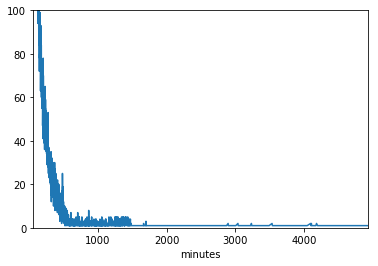

In [30]:
# Longer than 60 mins
ax = (tripTime[(tripTime > 60) & (tripTime < 5000)]).value_counts().sort_index().plot(ylim=[0, 100])
ax.set(xlabel='minutes')

In [31]:
len(df_trips[df_trips.duration_sec // 60 > 5000])

46

We could see that the majority of travel time of each trip is within 30 mins. This may be due to the pricing plan (overtime fee after 30 mins).

It may also be interesting to see the trip time distribution between different user (subsciption) types.

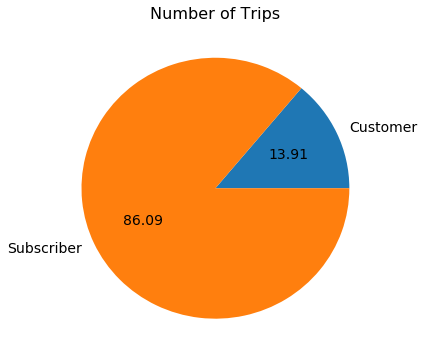

In [61]:
# Compare number of trips and total trip durations
numTripsByType = df_trips.groupby('subscriber_type').size()
numTripsByType.name=''
numTripsByType.plot.pie(autopct='%.2f', figsize=(6, 6), fontsize=14)
plt.title('Number of Trips', fontsize=16)

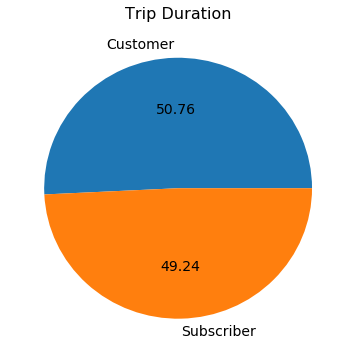

In [62]:
durationByType = df_trips[['duration_sec', 'subscriber_type']].groupby('subscriber_type').sum().duration_sec
durationByType.name = ''
durationByType.plot.pie(autopct='%.2f', figsize=(6, 6), fontsize=14)
plt.title('Trip Duration', fontsize=16)

In [75]:
df_trips['date'] = df_trips.start_date.dt.date
df_duration = df_trips[['date', 'subscriber_type', 'duration_sec']].groupby(['date', 'subscriber_type']).sum()
df_duration = df_duration.unstack('subscriber_type')
df_duration.head()

duration_sec           
subscriber_type     Customer Subscriber
date                                   
2013-08-29            681719     486131
2013-08-30           1705369     224668
2013-08-31           2223747     118726
2013-09-01           2281875     122703
2013-09-02           1434464     109174

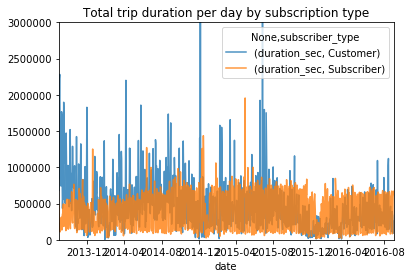

In [111]:
df_duration.plot(alpha=0.8)
plt.ylim((0, 3e6))
plt.title('Total trip duration per day by subscription type')

In [92]:
df_count = df_trips.groupby(['date', 'subscriber_type']).size()
df_count = df_count.unstack('subscriber_type')
df_count.head()

subscriber_type,Customer,Subscriber
date,,
2013-08-29,287,461
2013-08-30,406,308
2013-08-31,480,160
2013-09-01,584,122
2013-09-02,499,162


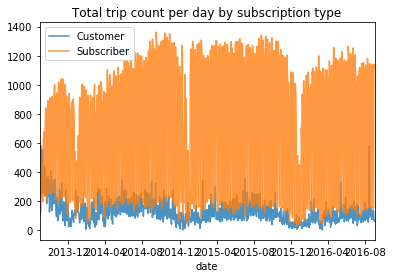

In [107]:
df_count.plot(alpha=0.8)
plt.legend(loc=2)
plt.title('Total trip count per day by subscription type')

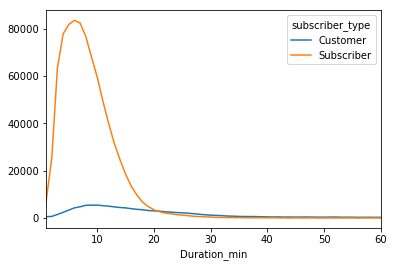

In [134]:
# Trip time distribution by subscription type (not normalized)
df_trips['Duration_min'] = df_trips.duration_sec // 60
t = df_trips.groupby(['Duration_min', 'subscriber_type']).size().unstack('subscriber_type')
t.head(60).plot()

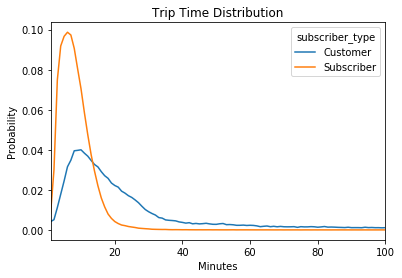

In [136]:
# Trip time distribution by subscription type (normalized)
t.Customer = t.Customer / t.Customer.sum()
t.Subscriber = t.Subscriber / t.Subscriber.sum()
ax = t.head(100).plot()
ax.set(xlabel='Minutes', ylabel='Probability', title='Trip Time Distribution')

From the trip data, we may also characterize the popularity of the stations

In [126]:
# Top 10 start stations
df_trips.groupby(['start_station_id', 'start_station_name']).size().sort_values(ascending=False).head(10)

start_station_id  start_station_name                           
70                San Francisco Caltrain (Townsend at 4th)         72683
69                San Francisco Caltrain 2 (330 Townsend)          56100
50                Harry Bridges Plaza (Ferry Building)             49062
60                Embarcadero at Sansome                           41137
61                2nd at Townsend                                  39936
55                Temporary Transbay Terminal (Howard at Beale)    39200
74                Steuart at Market                                38531
77                Market at Sansome                                35142
65                Townsend at 7th                                  34894
67                Market at 10th                                   30209
dtype: int64

In [127]:
# Top 10 end stations
df_trips.groupby(['end_station_id', 'end_station_name']).size().sort_values(ascending=False).head(10)

end_station_id  end_station_name                             
70              San Francisco Caltrain (Townsend at 4th)         92014
69              San Francisco Caltrain 2 (330 Townsend)          58713
50              Harry Bridges Plaza (Ferry Building)             50185
60              Embarcadero at Sansome                           46197
61              2nd at Townsend                                  44145
77              Market at Sansome                                40956
74              Steuart at Market                                39598
65              Townsend at 7th                                  38545
55              Temporary Transbay Terminal (Howard at Beale)    35477
76              Market at 4th                                    26762
dtype: int64

*Note: We may further combine google map data to explain the popularity of stations.

## Station bike / dock availability

Using the station status data, we may check the bike/dock availability for each station. The data contains the availability information with precision up to minutes.

We first arbitrarily select one station.

In [128]:
station_status = pd.read_csv('data/201402_babs_open_data/201402_status_data.csv')
station2_bike = station_status[station_status.station_id == 2][['bikes_available', 'time']]

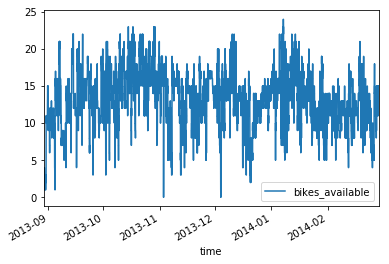

In [129]:
station2_bike.time = pd.to_datetime(station2_bike.time)
station2_bike.plot(x='time', y='bikes_available')

In [130]:
empty = station2_bike[station2_bike.bikes_available == 0].shape[0]
print 'The empty time duration of station 2 is: ', empty
print 'The total time duration is: ', station2_bike.shape[0]
print 'The empty time proportion (within the half-year time frame) is: ', float(empty)/station2_bike.shape[0]

The empty time duration of station 2 is:  74
The total time duration is:  260491
The empty time proportion (within the half-year time frame) is:  0.000284078912515


The total time duration of empty bike at station 2 is only 74 minutes (within a half-year time frame), which could be considered pretty nice. 

Now let's look at the distribution of the empty time over all stations.

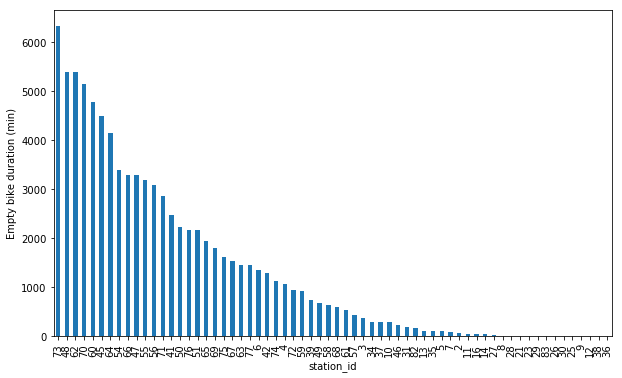

In [139]:
# Distribution of the total time duration where no bikes are available
zero_bike = station_status[station_status.bikes_available == 0]
ax = zero_bike.groupby('station_id').size().sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
ax.set(ylabel='Empty bike duration (min)')

In [168]:
print "The maximum empty duration per station is:", zero_bike.groupby('station_id').size().max()
print "(which translates to ", zero_bike.groupby('station_id').size().max() / float(len(station_status[station_status.station_id == 73])) * 100, "% of time)"

The maximum empty duration per station is: 6342
(which translates to  2.43466109763 % of time)


We could see that the empty time duration varies significantly among stations. In fact, the empty time of 74 minutes (station 2) we just saw happens to be a quite extreme case.

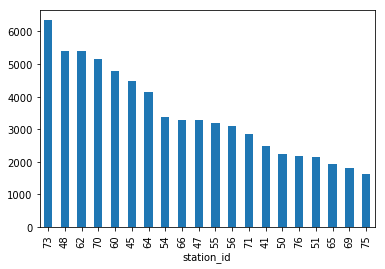

In [41]:
# Only plot the top 20 stations
zero_bike.groupby('station_id').size().sort_values(ascending=False).head(20).plot(kind='bar')

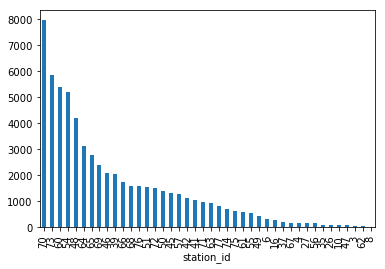

In [26]:
# Distribution of the total time duration where no docks are available
zero_dock = station_status[station_status.docks_available == 0]
zero_dock.groupby('station_id').size().sort_values(ascending=False).plot(kind='bar')

## Questions (unresolved)
Here we summarize some questions that occurred when performing the analysis, which may worth more exploration:

+ Comparing the station location and the current station map (on official website), it seems that some stations are closed now. What are the possible reasons for the shutdown?